## Installing / importing required libraries

In [48]:
! pip install surprise whoosh sentence_transformers

In [49]:
! pip install pandas matplotlib scipy scikit-learn

In [50]:
import math
import os
import pickle

import json
import logging
import sys
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor as GBRT
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts

from surprise import SVD, Dataset, KNNBaseline, Reader, SVDpp, KNNWithMeans, KNNWithZScore
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_pandas

from sentence_transformers import SentenceTransformer
from tqdm import trange, tqdm
from whoosh import fields, index, qparser, scoring

np.random.seed(42)
plt.rcParams.update({'font.size': 10})

## Mount google drive and set path for dataset

In [51]:
from google.colab import drive
drive.mount('/content/drive')
DATAPATH = '/content/drive/MyDrive/SEM 2/NLP/Project/data/'

# DATAPATH = 'data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## True to train models
## False to use preloaded models

In [52]:
REGENERATE = True
CREATE_INDEX = False

## Setting up schema and whoosh parser

In [53]:
schema = fields.Schema(movie_id=fields.KEYWORD(stored=True, scorable=True),
                       critic_id=fields.KEYWORD(stored=True, scorable=True),
                       score=fields.NUMERIC(stored=True),
                       review=fields.TEXT(stored=True),
                       freshness=fields.KEYWORD(scorable=True))
whoosh_parser = qparser.MultifieldParser(['movie_id', 'review'], schema=schema)
try:
    searcher = index.open_dir(DATAPATH + 'index').searcher(weighting=scoring.BM25F)
except index.EmptyIndexError:
    print(f'No index found in {DATAPATH} index')

## Utility functions

In [54]:
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        print(f'{func.__name__} took {round(time.time()-start)} seconds to complete')
        return result
    return wrapper

def get_average_score(x, y, model, n=100):
    rmses = []
    maes = []
    for _ in trange(n, leave=False, desc='running models'):
        x_train, x_test, y_train, y_test = tts(x, y, test_size=0.1)
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        rmses.append(math.sqrt(mse(y_test, predictions)))
        maes.append(mae(y_test, predictions))
    rmses = np.array(rmses)
    maes = np.array(maes)
    print(f'getting average metrics on {n} {type(model).__name__}s')
    print(f'avg RMSE: {round(rmses.mean(), 4)}, std: {round(np.std(rmses), 3)}')
    print(f'avg MAE:  {round(maes.mean(), 4)}, std: {round(np.std(maes), 3)}')
    return rmses

## Model configurations

In [55]:
model_features = ['cf_score',
                  'difference',
                  'dot_product',
                  'meta_genre',
                  'meta_people',
                  'meta_description',
                  'meta_title',
                  'meta_runtime',
                  'meta_date',
                  'meta_audience_score',
                  'meta_critics_score',
                  'meta_amount_critics',
                  'meta_amount_users']

num_bert_feats = 1024
bc = SentenceTransformer('stsb-roberta-large') 
cf_model = 'svd' #knn, knnzscore, svd, svdpp
outpath = DATAPATH + '/model_artifacts/sentiment/'

## Loading files

In [56]:
conversations = json.load(open(DATAPATH + 'MovieSent.json', 'r'))
movie_ids = json.load(open(DATAPATH + 'films_rt_ids.json', 'r'))
movies_features = json.load(open(DATAPATH + 'films_features.json', 'r'))

## creating indexes

In [57]:
@timeit
def indexing(df, index_name=DATAPATH + 'index'):
    os.makedirs(index_name, exist_ok=True)
    ix = index.create_in(index_name, schema)
    writer = ix.writer()
    print('Indexing reviews')
    for _, review in tqdm(df.iterrows(), total=df.shape[0], desc='adding reviews into index'):
        writer.add_document(
            movie_id=review['movie_id'],
            critic_id=review['critic_id'],
            review=review['review'],
            score=review['score'])
    print('Committing reviews. This will take a while')
    writer.commit()
    
df = pd.read_table(DATAPATH + 'reviews.tsv')
if CREATE_INDEX:
  indexing(df)

## Data engineering and cleaning

In [58]:
def entities_in_utterance(utterance):
    """ extract entities from the utterance """
    if 'segments' not in utterance:
        return set()
    ents = set()
    for segment in utterance['segments']:
        entity_type = 'entityType' in segment['annotations'][0] and segment['annotations'][0]['entityType'] == 'MOVIE_OR_SERIES'
        annotation_type = 'annotationType' in segment['annotations'][0] and segment['annotations'][0]['annotationType'] == 'ENTITY_NAME'
        if entity_type and annotation_type:
            if 'entityId' in segment['annotations'][0]:
                ents.add(segment['annotations'][0]['entityId'])
            else:
                ents.add(segment['text'])
    return ents


def merge_utts(utterances):
    """ merge utterances from the same speaker that apper in a row """
    cur_agent = utterances[0]['speaker']
    result = ''
    for utterance in utterances:
        if utterance['speaker'] == cur_agent:
            result += ' ' + utterance['text']
        else:
            result += ' ||| ' + utterance['text']
            cur_agent = utterance['speaker']
    return result.strip()


def get_sentiment_from_utterance(utterance):
    """ get the judge sentiment for the first entity in the utterance """
    for segment in utterance['segments']:
        if 'annotations' in segment and 'sentiment' in segment['annotations'][0]:
            intial_sentiment = segment['annotations'][0]['sentiment']
            if np.isnan(intial_sentiment[0]):
                return intial_sentiment[-1]
            elif np.isnan(intial_sentiment[-1]):
                return intial_sentiment[0]
            return sum(intial_sentiment) / len(intial_sentiment)
    print('sentiment not extracted from:', utterance)


def sentiment_2_score(x):
    """ convert [-3:+3] score to a [1:5] rating """
    try:
        return round((2 * x + 9) / 3)
    except Exception:
        return np.nan


def get_gbdt_conversations(conversations):
    """ convert original json conversations into pandas df
        and add estimated score
    """
    zero_reviewed = []
    for movie_id in movie_ids:
        results = searcher.search(whoosh_parser.parse(f'movie_id:{movie_id}'), limit=None)
        if len(results) == 0:
            zero_reviewed.append(movie_id)

    list_of_lines = []
    for conversation in conversations:
        entities = set()
        line = {'critic_id': conversation['conversationId']}
        for utterance in conversation['utterances']:
            cur_ents = entities_in_utterance(utterance)
            if utterance['speaker'] == 'USER' and 'segments' in utterance and len(cur_ents) == 1:
                movie_id = list(cur_ents)[0]
                movie_sentiment = sentiment_2_score(get_sentiment_from_utterance(utterance))
                valid_id = movie_id not in entities and movie_id not in zero_reviewed and movie_id in movie_ids
                valid_score = len(entities) < 2 or not np.isnan(movie_sentiment)
                if valid_id and valid_score:
                    if len(entities) == 0:
                        line['first movie_id'] = movie_id
                        line['first score'] = movie_sentiment
                        line['first text'] = get_context(conversation, utterance)
                    elif len(entities) == 1:
                        line['second movie_id'] = movie_id
                        line['second score'] = movie_sentiment
                        line['second text'] = get_context(conversation, utterance)
                        line['review'] = merge_utts(conversation['utterances'][:utterance['index'] + 1])
                    elif len(entities) == 2:
                        line['target movie_id'] = movie_id
                        line['target score'] = movie_sentiment
                        list_of_lines.append(line)
                        break
                    entities.add(movie_id)
    return pd.DataFrame.from_records(list_of_lines)


def get_context(conversation, utterance):
    if utterance['index'] > 0 and conversation['utterances'][utterance['index'] - 1]['speaker'] == 'ASSISTANT':
        text = conversation['utterances'][utterance['index'] - 1]['text'] + ' ||| ' + utterance['text']
    else:
        text = utterance['text']
    return text


## Training sentiment model

In [59]:
def create_sentiment_trainset(file):
    """ use utterances from conversations that can't be used
        for the final model to train sentiment estimator on them
    """
    forbidden_pairs = []
    for column in ['first movie_id', 'second movie_id', 'target movie_id']:
        forbidden_pairs += [list(i) for i in df_conv[['critic_id', column]].values]

    list_of_lines = []
    for conversation in conversations:
        for utterance in conversation['utterances']:
            line = {'critic_id': conversation['conversationId']}
            cur_ents = entities_in_utterance(utterance)
            if utterance['speaker'] == 'USER' and 'segments' in utterance and len(cur_ents) == 1:
                movie_id = list(cur_ents)[0]
                movie_sentiment = sentiment_2_score(get_sentiment_from_utterance(utterance))
                if [conversation['conversationId'], movie_id] not in forbidden_pairs and not np.isnan(movie_sentiment):
                    line['movie_id'] = movie_id
                    line['score'] = movie_sentiment
                    line['text'] = get_context(conversation, utterance)
                    list_of_lines.append(line)
    trainset = pd.DataFrame.from_records(list_of_lines)
    trainset[['text', 'score']].to_csv(file, sep='\t', index=False)


@timeit
def train_estimator(sentiment_df):

    # embed the train dataset
    emb_path = outpath + 'trainset_embeddings.txt'
    if REGENERATE or not os.path.exists(model_path):
        print('Calculating embeddings')
        sentiment_estimation_embeddings = bc.encode(sentiment_df['text'].to_list())
        print('Embeddings calculated')
        np.savetxt(emb_path, sentiment_estimation_embeddings)
    sentiment_estimation_embeddings = np.loadtxt(emb_path)

    # remove those few conversations which have score 3 to reduce noise
    indexes = sentiment_df[sentiment_df['score'] == 3].index.to_list()
    sentiment_df = sentiment_df[sentiment_df['score'] != 3]
    sentiment_estimation_embeddings = [i for ind, i in enumerate(sentiment_estimation_embeddings) if ind not in indexes]

    print('Fitting the estimator')
    x_train, x_test, y_train, y_test = tts(sentiment_estimation_embeddings, sentiment_df['score'], test_size=0.1)
    model = RFR(n_estimators=500, max_depth=10, n_jobs=-1)
    model.fit(x_train, y_train)
    print('Estimator fitted')

    pickle.dump(model, open(model_path, 'wb'))
    y_pred = model.predict(x_test)
    print(f'sentiment estimator RMSE: {round(math.sqrt(mse(y_test, y_pred)), 3)}')
    print(f'sentiment estimator  MAE: {round(mae(y_test, y_pred), 3)}')
    print(f'sentiment estimator  R^2: {round(model.score(x_test, y_test), 3)}')


In [60]:
df_conv = get_gbdt_conversations(conversations)
model_path = outpath + 'estimator.pickle'
trainset_path = outpath + 'trainset.tsv'

os.makedirs(outpath, exist_ok=True)
if REGENERATE or not os.path.exists(model_path):
    if REGENERATE or not os.path.exists(trainset_path):
        create_sentiment_trainset(trainset_path)
    sentiment_df = pd.read_table(trainset_path)
    train_estimator(sentiment_df)
model = pickle.load(open(model_path, 'rb'))

print('Encoding conversations')
embeddings = bc.encode(df_conv['first text'].tolist() + df_conv['second text'].tolist(), show_progress_bar=False)
df_conv['first score'] = model.predict(embeddings[:df_conv.shape[0]])
df_conv['second score'] = model.predict(embeddings[df_conv.shape[0]:])
print('Encoding done')

df_conv.drop(['first text', 'second text'], axis=1, inplace=True)
df_conv.to_csv(outpath + '/conversations_estimated.tsv', sep='\t', index=False)

Calculating embeddings
Embeddings calculated
Fitting the estimator
Estimator fitted
sentiment estimator RMSE: 0.685
sentiment estimator  MAE: 0.527
sentiment estimator  R^2: 0.759
train_estimator took 93 seconds to complete
Encoding conversations
Encoding done


## Training CF model

In [61]:
def get_ranked_critics(movie_id, text):
    ''' returns dict of ranked according to text critics with BM25 weights '''
    query = whoosh_parser.parse(f'movie_id:{movie_id} AND (review:' + ' OR review:'.join(text.split()) + ')')
    initial_list = [(i['critic_id'], i.score) for i in searcher.search(query, limit=None)]
    if len(initial_list) > 0:
        biggest_weight = initial_list[0][1]
        return {i[0]: i[1] / biggest_weight for i in initial_list}
    print(f'found 0 bm25 reviews for {movie_id}')
    return {}


def get_movie_critic_representation(row):
    '''
        returns movie vector, created using embeddings
        of critics' reviews' and their BM25 weights
    '''
    critics_dict = get_ranked_critics(row.movie_id, row.review)
    subdf = critics_reviews[critics_reviews['movie_id'] == row.movie_id]
    subsubdf = subdf[subdf['critic_id'].isin(critics_dict.keys())]
    if len(critics_dict) > 0:
        encodings = bc.encode(subsubdf['review'].to_list(), show_progress_bar=False)
        weights = [critics_dict[name] for name in subsubdf['critic_id'].to_list()]
        weights = np.array(weights).reshape((len(weights), 1))
        return (encodings * weights).mean(axis=0)
    return np.zeros(num_bert_feats)


@timeit
def train_cf(df, model):
    reader = Reader(rating_scale=(1, 5))
    print('training ' + model)
    if model == 'knn':
        algo = KNNBaseline(sim_options={'name': 'cosine', 'user_based': True}, verbose=False)
    elif model == 'knnmeans':
        algo = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True}, verbose=False)
    elif model == 'knnzscore':
        algo = KNNWithZScore(sim_options={'name': 'cosine', 'user_based': True}, verbose=False)
    elif model == 'svd':
        algo = SVD(n_factors=500)
    elif model == 'svdpp':
        algo = SVDpp(n_factors=500, n_epochs = 1)
    data_train = Dataset.load_from_df(df, reader)
    algo.fit(data_train.build_full_trainset())
    pickle.dump(algo, open(outpath + f'cf_{model}.pkl', 'wb'))


def convert_to_cf_matrix(df):
    ''' converts df_users into a standard records cf matrix '''
    result = pd.DataFrame()
    for number in ['first', 'second']:
        temp = df[['critic_id', number + ' movie_id', number + ' score']].drop_duplicates()
        temp = temp.rename(columns={number + ' movie_id': 'movie_id', number + ' score': 'score'})
        result = result.append(temp)
    return result


def get_cf_feature(df, model, REGENERATE):
    if not os.path.exists(outpath + 'cf.pkl') or REGENERATE:
        df_users_cf = convert_to_cf_matrix(df)
        df_cf = critics_reviews[['critic_id', 'movie_id', 'score']].append(df_users_cf).reset_index(drop=True).dropna()
        train_cf(df_cf, model)
    cf = pickle.load(open(outpath + f'cf_{model}.pkl', 'rb'))

    df['cf_score'] = df.apply(lambda x: cf.predict(x['critic_id'], x['target movie_id']).est, axis=1)
    print(f"RMSE for CF: {math.sqrt(mse(df['cf_score'], df['target score']))}")
    print(f" MAE for CF: {mae(df['cf_score'], df['target score'])}")
    df.to_csv(outpath + 'conversations_w_cf.tsv', sep='\t', index=False)


@timeit
def get_users_emb(df, each_turn='full_text'):
    '''
        options for embedding calculation:
            each_turn: takes the average embedding of turns' embeddings
            full_text: takes the embedding of all text concatenated
    '''
    print('getting user embedding')
    columns = [f'user_{i}' for i in range(num_bert_feats)]
    if each_turn == 'each_turn':
        embedded = [bc.encode(i, show_progress_bar=False).mean(axis=0) for i in df['review'].progress_apply(lambda x: x.split(' ||| ')).to_list()]
        user_emb = pd.DataFrame.from_records(embedded, columns=columns)
    else:
        user_emb = pd.DataFrame.from_records(bc.encode(df['review'].to_list(), show_progress_bar=False), columns=columns)
    user_emb.to_csv(outpath + f'users_emb_{each_turn}.tsv', sep='\t', index=False)


@timeit
def get_critics_emb(df):
    print('getting critic embedding')
    tqdm_pandas.pandas(desc='critics_emb')
    df_tmp = df.rename(columns={'target movie_id': 'movie_id'}).reset_index(drop=True)
    df_tmp = df_tmp.progress_apply(get_movie_critic_representation, axis=1)
    critics_emb = pd.DataFrame.from_records(df_tmp, columns=[f'critics_emb_{i}' for i in range(num_bert_feats)])
    critics_emb.to_csv(outpath + 'critics_emb.tsv', sep='\t', index=False)


@timeit
def get_metadata_features(df, user_vectors):
    print('getting metadata features')
    new_feats = []
    for i, user in enumerate(tqdm(user_vectors, desc='metadata features')):
        row = df.iloc[i].copy()
        current_movie_features = movies_features[row['target movie_id']]
        for feature in ['genre', 'people', 'description', 'title']:
            if feature not in current_movie_features or current_movie_features[feature] == []:
                print(f"no {feature} for {row['target movie_id']}")
        if 'audience_score' not in current_movie_features or 'critic_score' not in current_movie_features:
            print('no scores for ', row['target movie_id'])
            row['meta_audience_score'] = np.nan
            row['meta_critics_score'] = np.nan
        else:
            row['meta_audience_score'] = current_movie_features['audience_score'] / 100
            row['meta_critics_score'] = current_movie_features['critic_score'] / 100

        to_encode = [', '.join(current_movie_features['genre']),
                     ', '.join(current_movie_features['people'][:10]),
                     current_movie_features['description'],
                     current_movie_features['title']]
        for i in range(len(to_encode)):
            if len(to_encode[i]) == 0:
                to_encode[i] = 'None'
        genre_vector, people_vector, descr_vector, title_vector = bc.encode(to_encode, show_progress_bar=False)

        row['meta_date'] = current_movie_features['in theaters']
        row['meta_runtime'] = current_movie_features['runtime']
        row['meta_amount_critics'] = current_movie_features['amount of critics']
        row['meta_amount_users'] = current_movie_features['amount of users']
        row['meta_genre'] = np.dot(user, np.transpose(genre_vector))
        row['meta_people'] = np.dot(user, np.transpose(people_vector))
        row['meta_description'] = np.dot(user, np.transpose(descr_vector))
        row['meta_title'] = np.dot(user, np.transpose(title_vector))
        new_feats.append(row)
    return pd.DataFrame.from_records(new_feats)


def get_all_features(df_users, model, regenerate=False):
    """ prepare a dataframe with all the features """

    print('generating data')
    if not os.path.exists(outpath + 'conversations_w_cf.tsv') or regenerate:
        get_cf_feature(df_users, model, regenerate)
    if not os.path.exists(outpath + 'users_emb_full_text.tsv') or regenerate:
        get_users_emb(df_users)
    if not os.path.exists(outpath + 'critics_emb.tsv') or regenerate:
        get_critics_emb(df_users)

    df_users = pd.read_table(outpath + 'conversations_w_cf.tsv')
    user_vectors = pd.read_table(outpath + 'users_emb_full_text.tsv').values.tolist()
    critics_vectors = pd.read_table(outpath + 'critics_emb.tsv').values.tolist()

    earth_movers_distance = [[stats.wasserstein_distance(critics_vectors[i], user)] for i, user in enumerate(user_vectors)]
    dot_product = [[np.dot(user, np.transpose(critics_vectors[i]))] for i, user in enumerate(user_vectors)]
    emd_df = pd.DataFrame.from_records(earth_movers_distance, columns=['difference'])
    dp_df = pd.DataFrame.from_records(dot_product, columns=['dot_product'])

    df_users = pd.concat([df_users.reset_index(drop=True), emd_df, dp_df], axis=1)
    df_all_features = get_metadata_features(df_users, user_vectors)
    df_all_features.to_csv(df_all_features_path, sep='\t', index=False)

## GBRT/Final recommender model

generating data
training svd
train_cf took 234 seconds to complete
RMSE for CF: 1.2012458269134811
 MAE for CF: 0.9710729021712049
getting user embedding
get_users_emb took 6 seconds to complete
getting critic embedding


critics_emb:   0%|          | 0/236 [00:00<?, ?it/s]

get_critics_emb took 420 seconds to complete
getting metadata features


metadata features:  69%|██████▊   | 162/236 [00:16<00:06, 10.95it/s]

no people for star_wars_episode_vii_the_force_awakens


metadata features: 100%|██████████| 236/236 [00:23<00:00,  9.98it/s]


get_metadata_features took 24 seconds to complete


getting average metrics on 10 GradientBoostingRegressors
avg RMSE: 1.1363, std: 0.156
avg MAE:  0.8692, std: 0.133
RMSE: 1.0632015700435271
 MAE: 0.8013597921931804
Feature importances:


getting average metrics on 20 GradientBoostingRegressors
avg RMSE: 1.1318, std: 0.146
avg MAE:  0.8671, std: 0.12
RMSE: 1.0941508506758564
 MAE: 0.8078029367802225
Feature importances:


getting average metrics on 30 GradientBoostingRegressors
avg RMSE: 1.1082, std: 0.179
avg MAE:  0.8635, std: 0.155
RMSE: 1.1306228906257239
 MAE: 0.830173181150518
Feature importances:


getting average metrics on 40 GradientBoostingRegressors
avg RMSE: 1.1519, std: 0.148
avg MAE:  0.9006, std: 0.153
RMSE: 1.147467121009039
 MAE: 0.8650455853908846
Feature importances:


getting average metrics on 50 GradientBoostingRegressors
avg RMSE: 1.1547, std: 0.162
avg MAE:  0.8925, std: 0.142
RMSE: 1.1651002335063847
 MAE: 0.8929447269385125
Feature importances:


getting average metrics on 60 GradientBoostingRegressors
avg RMSE: 1.2148, std: 0.167
avg MAE:  0.9528, std: 0.154
RMSE: 1.1921816965133158
 MAE: 0.9096288313536101
Feature importances:


getting average metrics on 70 GradientBoostingRegressors
avg RMSE: 1.203, std: 0.165
avg MAE:  0.9493, std: 0.15
RMSE: 1.223528542337204
 MAE: 0.9365311890303968
Feature importances:


getting average metrics on 80 GradientBoostingRegressors
avg RMSE: 1.1979, std: 0.169
avg MAE:  0.9483, std: 0.147
RMSE: 1.219849292389035
 MAE: 0.9383154722244239
Feature importances:


getting average metrics on 90 GradientBoostingRegressors
avg RMSE: 1.1782, std: 0.163
avg MAE:  0.9227, std: 0.14
RMSE: 1.2398863508940172
 MAE: 0.9491929698807304
Feature importances:


getting average metrics on 100 GradientBoostingRegressors
avg RMSE: 1.1667, std: 0.157
avg MAE:  0.9199, std: 0.138
RMSE: 1.2503138284849395
 MAE: 0.9456702181801715
Feature importances:


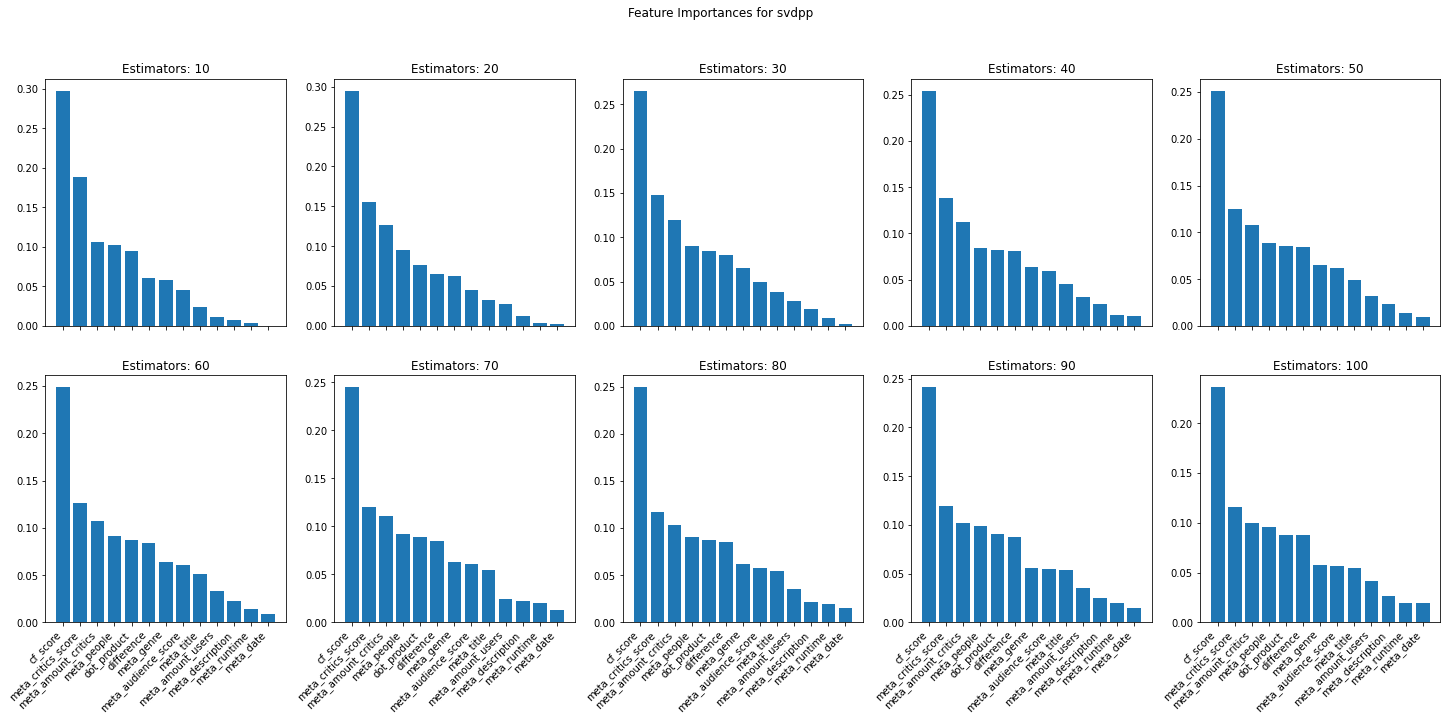

In [62]:
critics_reviews = pd.read_table(DATAPATH + 'reviews.tsv').drop(['fresh'], axis=1).dropna()

df_users = pd.read_table(outpath + 'conversations_estimated.tsv')
df_users = df_users[df_users['target movie_id'].isin(movies_features)]

df_all_features_path = outpath + 'conversations_w_features.tsv'
if not os.path.exists(df_all_features_path) or REGENERATE:
    get_all_features(df_users, cf_model, REGENERATE)
df_all_features = pd.read_table(df_all_features_path)

rmse_res, mae_res = [], []

counter = 0
fig, axs = plt.subplots(2, 5, figsize=(25, 10), sharex= True)
axs = axs.flatten()


for n_est in range(10, 101, 10): 
  model = GBRT(n_estimators=n_est, max_depth=3)
  X, y = df_all_features[model_features + ['target movie_id']], df_all_features['target score']
  get_average_score(X.drop('target movie_id', axis=1), y, model, n=n_est)
  X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)
  model.fit(X_train.drop('target movie_id', axis=1), y_train)
  y_pred = model.predict(X_test.drop('target movie_id', axis=1))
  rmse_res.append(math.sqrt(mse(y_test, y_pred)))
  mae_res.append(mae(y_test, y_pred))
  print(f'RMSE: {rmse_res[-1]}')
  print(f' MAE: {mae_res[-1]}')
  pickle.dump(model, open(outpath + 'gbdt' + str(n_est) + '.pkl', 'wb'))


  features = []
  importances = []
  print('Feature importances:')
  for score, feature in sorted(zip(model.feature_importances_, model_features), reverse=True):
    # print(f'{round(score, 4)} {feature}')
    importances.append(score)
    features.append(feature)

  axs[counter].bar(features, importances)
  axs[counter].set_title('Estimators: ' + str(n_est))
  plt.setp(axs[counter].get_xticklabels(), rotation = 45, horizontalalignment = 'right')
  fig.suptitle('Feature Importances for svdpp')
  # plt.bar(features, importances)
  counter += 1

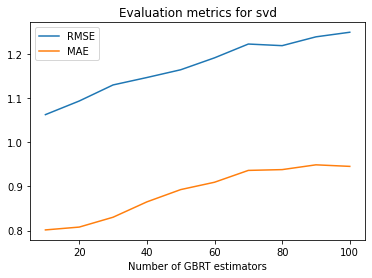

In [64]:
plt.title('Evaluation metrics for ' + cf_model)
plt.xlabel('Number of GBRT estimators')
plt.plot(range(10, 101, 10), rmse_res, label='RMSE')
plt.plot(range(10, 101, 10), mae_res, label='MAE')
plt.legend()